# Turnpike

We consider the following optimal control problem:

$$ \int_0^{2} x^2(t)\,\mathrm{d}t \to \min, $$

where

$$ \dot{x}(t) = u(t),\quad |u(t)| \leq 1, $$

$$ x(0)=1,\quad x(2)=1/2. $$

<div class="alert alert-info">

**_Question._**
    
Solve the optimal control problem with `Jump` and `Ipopt`.
      
</div>

In [8]:
using JuMP, Ipopt

# Create JuMP model, using Ipopt as the solver
turnpike = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 5))

# Parameters
t0 = 0.    # initial time
tf = 2.    # final time
c0 = 0.    # Initial cost
x0 = 1.    # Initial position
xf = 0.5   # Final position

n  = 800    # Grid size
Δt = (tf - t0) / n  # Time step

#
# Define the variables (@variables), the objective (@objective), the limit constraints (@constraints)
# and the dynamic constraints (@NLconstraint)
#
# We consider the cost has an additional variable: c(0) = 0 and c(2) is free.
# The dynamics for the cost is dc = x^2 and the objective function is simple c(2)
#

@variables(turnpike, begin
    # State variables
    c[1:n] ≥ 0            # Cost
    x[1:n] ≥ 0            # Position
    1 ≥ u[1:n] ≥ -1       # Control
end)

# Objective: maximize altitude at end of time of flight
@objective(turnpike, 
    Min, c[n]
)

# Initial conditions
@constraints(turnpike, begin
    x[1] == x0
    c[1] == c0
    x[n] == xf
end)

# Dynamics
for j in 2:n  
    # dc = x^2
    # cost dynamics

    # Trapezoidal integration
    @NLconstraint(turnpike,
        c[j] == c[j - 1] + 0.5 * Δt * (x[j] ^ 2 + x[j - 1] ^ 2))

    # dx = u
    # state dynamics

    # Trapezoidal integration
    @NLconstraint(turnpike,
        x[j] == x[j - 1] + 0.5 * Δt * (u[j] + u[j - 1]))
end


# Solve for the control and state
println("Solving...")
status = optimize!(turnpike)

# Display results
println("Solver status: ", status)
println("Minimum cost: ", objective_value(turnpike))

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     6395
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1598

Total number of variables............................:     2400
                     variables with only lower bounds:     1600
                variables with lower and upper bounds:      800
                     variables with only upper bounds:        0
Total numb

In [9]:
# Can visualize the state and control variables
using Gadfly

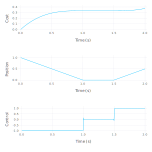

In [11]:
c_plot = plot(x = (1:n) * Δt, y = value.(c)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Cost"))
x_plot = plot(x = (1:n) * Δt, y = value.(x)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Position"))
u_plot = plot(x = (1:n) * Δt, y = value.(u)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Control"))
draw(SVG(6inch, 6inch), vstack(c_plot, x_plot, u_plot))